## 7.2 VGGNet(2014)
* 다양한 합성곱 신경망 모델중 가장 대중적으로 사용되는 VGGNet을 실습해 봅니다. 우선, 라이브러리를 로드합니다. 예측에 사용할 정답값을 폴더명을 사용해서 만들어 줍니다. OpenCV를 통해 이미지를 로드하고 이미지의 사이즈가 모두 동일하게 변경합니다. 이미지를 numpy의 배열 형태로 만듭니다. LabelEncoder를 통해 예측값을 수치 데이터로 변경합니다. 학습, 검증 데이터를 나눕니다. 학습하기에 적절한 형태의 배열 형태로 변경합니다. 19개의 층을 사용하는 VGG19 모델을 tensorflow.keras.applications.vgg19을 통해 불러옵니다. 모델을 만들고 컴파일을 합니다.
* 이를 바탕으로 학습을 진행합니다. 에포크를 통해 학습 횟수를 적절하게 조정하면 성능이 좀 더 좋아집니다. 학습한 내용을 history 로 받아 결과를 시각화 해봅니다. 학습세트의 정확도가 점점 높아지고 검증세트도 성능이 좋아지지만 어느 순간 정체하게 됩니다. 시각화를 통해 정확도와 손실률이 에포크를 더해갈 수록 변화하는 수치를 확인해 볼 수 있습니다. 학습이 잘 되었다면 테스트 세트를 통해 예측을 합니다. 예측이 되었다면 실제값과의 차이를 비교해 봅니다.


In [1]:
# 라이브러리를 로드합니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# 예측에 사용할 정답값을 폴더명을 사용해서 만들어 줍니다.
import os
root_dir = "images/"
image_label = os.listdir(root_dir)
image_label.remove("test.csv")
image_label.remove("alien_test")
image_label

['cloudy', 'shine', 'sunrise', 'rainy', 'foggy']

In [3]:
# OpenCV를 통해 이미지를 로드하고 이미지의 사이즈가 모두 동일하게 변경합니다.
import cv2
import tqdm as tqdm
x = []
y = [] 
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [4]:
for img_label in image_label:
    x,y = create_dataset(f"{root_dir}{img_label}", img_label)

100%|██████████| 300/300 [00:01<00:00, 157.23it/s]


In [5]:
# 이미지를 numpy의 배열 형태로 만듭니다.
x = np.array(x)
y = np.array(y)
x.shape,y.shape

((1498, 150, 150, 3), (1498,))

In [6]:
# LabelEncoder를 통해 예측값을 수치 데이터로 변경합니다.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# 학습, 검증 데이터를 나눕니다.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
# 학습하기에 적절한 형태의 배열 형태로 변경합니다.
img_size =150

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0


x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

In [9]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

In [10]:
y_train_lb.shape,y_test_lb.shape

((1198, 5), (300, 5))

## VGG19 

In [11]:
# 19개의 층을 사용하는 VGG19 모델을 불러옵니다.
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

In [12]:
for layer in vgg.layers:
    layer.trainable = False

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5,activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 40965     
Total params: 20,065,349
Trainable params: 40,965
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [16]:
unique,counts = np.unique(y_train_lb, return_counts=True)
print(unique,counts)

[0 1] [4792 1198]


In [17]:
batch_size=32
history =  model.fit(x_train, y_train_lb, epochs=15, validation_data=(x_test, y_test_lb),
                     batch_size=32 ,verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/15
38/38 [==============================] - ETA: 0s - loss: 1.0370 - accuracy: 0.6093
Epoch 00001: val_accuracy improved from -inf to 0.78333, saving model to vgg19.h5
38/38 [==============================] - 113s 3s/step - loss: 1.0370 - accuracy: 0.6093 - val_loss: 0.6235 - val_accuracy: 0.7833
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.8456
Epoch 00002: val_accuracy improved from 0.78333 to 0.81667, saving model to vgg19.h5
38/38 [==============================] - 114s 3s/step - loss: 0.4895 - accuracy: 0.8456 - val_loss: 0.4737 - val_accuracy: 0.8167
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8948
Epoch 00003: val_accuracy improved from 0.81667 to 0.84000, saving model to vgg19.h5
38/38 [==============================] - 111s 3s/step - loss: 0.3631 - accuracy: 0.8948 - val_loss: 0.4312 - val_accuracy: 0.8400
Epoch 4/15
38/38 [==============================] - ETA: 0s - loss: 0.2924 -

In [18]:
loss, accuracy = model.evaluate(x_test, y_test_lb)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")     

10/10 [==============================] - 17s 2s/step - loss: 0.2907 - accuracy: 0.9033
Loss: 0.29070132970809937
Accuracy: 0.903333306312561


In [19]:
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,1.037013,0.609349,0.623510,0.783333
1,0.489470,0.845576,0.473671,0.816667
2,0.363113,0.894825,0.431182,0.840000
3,0.292407,0.924040,0.376074,0.863333
4,0.231556,0.946578,0.371811,0.890000


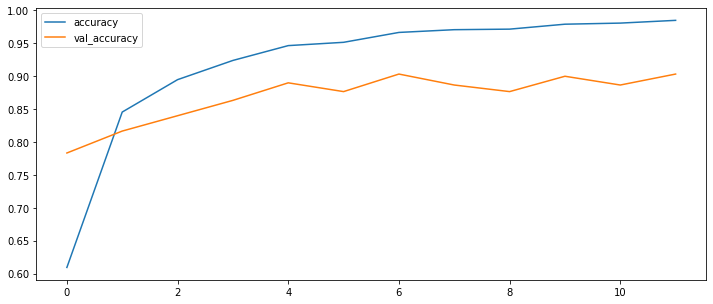

In [20]:
df_hist[["accuracy", "val_accuracy"]].plot(figsize=(12, 5))

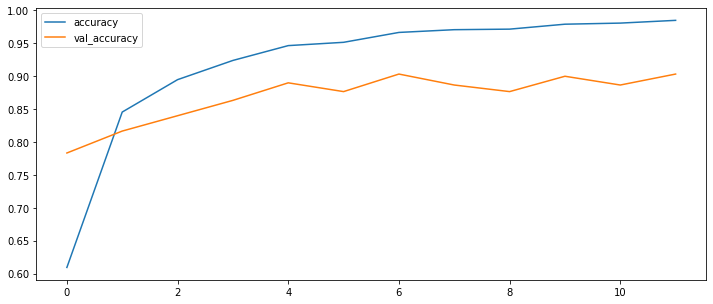

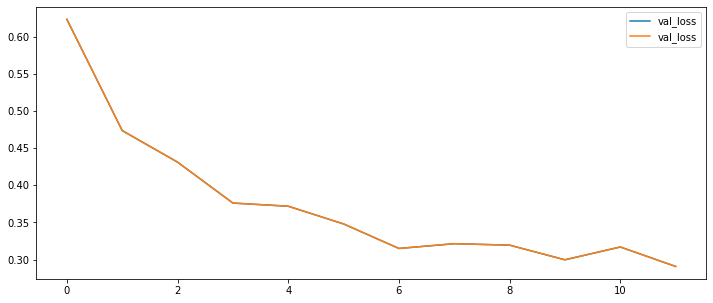

In [21]:
df_hist[["accuracy", "val_accuracy"]].plot(figsize=(12, 5))
df_hist[["val_loss", "val_loss"]].plot(figsize=(12, 5))

In [22]:
# 학습한 내용을 바탕으로 예측을 합니다.
y_pred = model.predict_classes(x_test)
y_pred[:15]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([2, 1, 1, 1, 4, 4, 2, 4, 3, 0, 4, 2, 2, 1, 0])

In [ ]:
# 예측값과 실제값을 비교해 봅니다.
plt.figure(figsize=(12,9))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    plt.subplot(2, 5, i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(x_test[sample])
    plt.xlabel(f"Actual: {y_test[sample]}\n Predicted: {y_pred[sample]}")
    
plt.tight_layout()    
plt.show()                       